In [1]:
import csv
from scipy.stats import pearsonr
import numpy as np
from sklearn.metrics import mean_squared_error
from pylab import *
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))*100

In [3]:
def percentage_error(y_true, y_pred):
    return ((y_true - y_pred) / y_true)*100

In [5]:
values_auto = {}
values_proxy = {}
all_flu = {}
all_proxy = {}
all_weeks = {}

years = range(2010, 2014)
for year in years:
    print "Year %d" %year
    weeks = range(1,5)
    for week in weeks:
        if week not in all_flu:
            all_flu[week] = {}
            all_proxy[week] = {}
            all_weeks[week] = {}
        tops = range(1, 6)
        for top in tops:
            
            weeks_predict = []

            f_predictions_proxy = open("../Data/Predictions/rbf_basket%d_tar%d_pattern%d.csv" % (top, week, year))
            
            predictions_reader_proxy = csv.DictReader(f_predictions_proxy, delimiter=',', quotechar=',')
            for row in predictions_reader_proxy:
                weeks_predict.append(row['time'])
            f_predictions_proxy.close()

            flu = []

            f_flu = open("../Data/Influenza/single_time_series_influenza_2010-2015_normalised.csv")
            flu_reader = csv.DictReader(f_flu, delimiter=' ', quotechar=',')
            for row in flu_reader:
                if row['Week'] in weeks_predict:
                    if float(row['TimeSeries']) >= 0.02 :
                        values_proxy[row['Week']] = {}
                        values_proxy[row['Week']]['real'] = float(row['TimeSeries'])
                        values_auto[row['Week']] = {}
                        values_auto[row['Week']]['real'] = float(row['TimeSeries'])
                        flu.append(float(row['TimeSeries']))
            f_flu.close()

            predictions_auto = []
            weeks_auto = []

            f_predictions_auto = open("../Predictions/rbf_AR_tar%d.csv" %week)
            predictions_reader = csv.DictReader(f_predictions_auto, delimiter=',', quotechar=',')
            for row in predictions_reader:
                if row['time'] in values_auto:
                    predictions_auto.append(float(row['preds']))
                    values_auto[row['time']]['predicted'] = row['preds']
                    weeks_auto.append(row['time'])
            f_predictions_auto.close()

            predictions_proxy = []
            weeks_proxy = []

            f_predictions_proxy = open("../Data/Predictions/rbf_basket%d_tar%d_pattern%d.csv" % (top, week, year))
            
            predictions_reader_proxy = csv.DictReader(f_predictions_proxy, delimiter=',', quotechar=',')
            for row in predictions_reader_proxy:
                if row['time'] in values_proxy:
                    predictions_proxy.append(float(row['preds']))
                    values_proxy[row['time']]['predicted'] = row['preds']
                    weeks_proxy.append(row['time'])
            f_predictions_proxy.close()
            
            
            if top not in all_flu[week]:
                all_flu[week][top] = flu
                all_proxy[week][top] = predictions_proxy
                all_weeks[week][top] = weeks_proxy
            else:
                all_flu[week][top].extend(flu)
                all_proxy[week][top].extend(predictions_proxy)
                all_weeks[week][top].extend(weeks_proxy)
 
        all_proxy[week]["auto"] = predictions_auto
    

Year 2010
Year 2011
Year 2012
Year 2013


## Calculate the statistics

In [6]:
weeks = range(1,5)
for week in weeks:
    print "Week%d: Pearson MAPE RMSE Relative-Efficiency" %week
    tops = range(1, 6)
    for top in tops:
        
        correlation_proxy = pearsonr(all_flu[week][top], all_proxy[week][top])[0]

        total_MAPE_proxy = mean_absolute_percentage_error(all_flu[week][top], all_proxy[week][top])
        total_MSE_proxy = mean_squared_error(all_flu[week][top], all_proxy[week][top])
        total_RMSE_proxy = sqrt(total_MSE_proxy)
        # relative efficiency
        total_MSE_auto = mean_squared_error(all_flu[week][top], all_proxy[week]["auto"])
        relative_efficiency = total_MSE_auto/total_MSE_proxy
        print "Top %d : %.2f %.2f %.2f %.2f" %(top, correlation_proxy, total_MAPE_proxy, total_RMSE_proxy*100, relative_efficiency)
        
    correlation_auto = pearsonr(all_flu[week][top], all_proxy[week]["auto"])[0]
    total_MAPE_auto = mean_absolute_percentage_error(all_flu[week][top], all_proxy[week]["auto"])
    total_RMSE_auto = sqrt(total_MSE_auto)
    print "Autoregression : %.2f %.2f %.2f\n" %(correlation_auto, total_MAPE_auto, total_RMSE_auto*100)

Week1: Pearson MAPE RMSE Relative-Efficiency
Top 1 : 0.96 8.77 0.74 1.14
Top 2 : 0.96 10.74 0.75 1.12
Top 3 : 0.96 10.70 0.80 0.98
Top 4 : 0.96 11.12 0.73 1.19
Top 5 : 0.96 11.80 0.75 1.11
Autoregression : 0.95 9.79 0.79

Week2: Pearson MAPE RMSE Relative-Efficiency
Top 1 : 0.94 11.48 0.99 2.36
Top 2 : 0.93 12.48 1.02 2.26
Top 3 : 0.94 12.65 0.99 2.36
Top 4 : 0.95 12.40 0.87 3.06
Top 5 : 0.94 13.48 0.95 2.57
Autoregression : 0.82 19.65 1.53

Week3: Pearson MAPE RMSE Relative-Efficiency
Top 1 : 0.94 12.29 0.97 3.47
Top 2 : 0.93 14.49 0.99 3.32
Top 3 : 0.92 15.06 1.06 2.92
Top 4 : 0.93 15.37 1.02 3.11
Top 5 : 0.93 14.77 1.02 3.13
Autoregression : 0.76 24.15 1.81

Week4: Pearson MAPE RMSE Relative-Efficiency
Top 1 : 0.91 16.65 1.24 2.05
Top 2 : 0.86 18.72 1.44 1.52
Top 3 : 0.87 18.16 1.38 1.66
Top 4 : 0.89 17.23 1.25 2.01
Top 5 : 0.87 17.62 1.35 1.74
Autoregression : 0.77 27.79 1.77



## Graphs

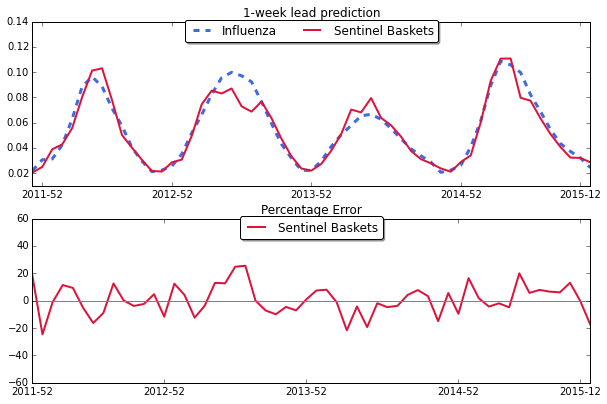

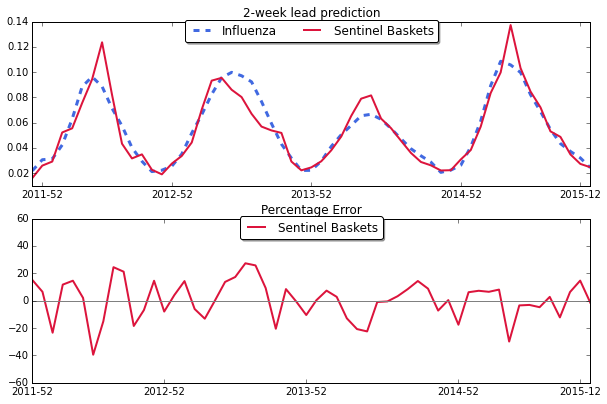

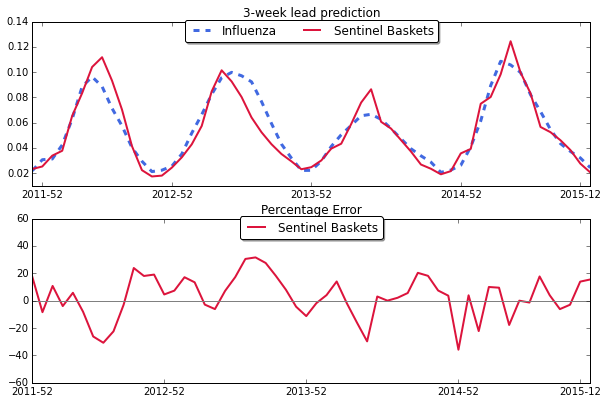

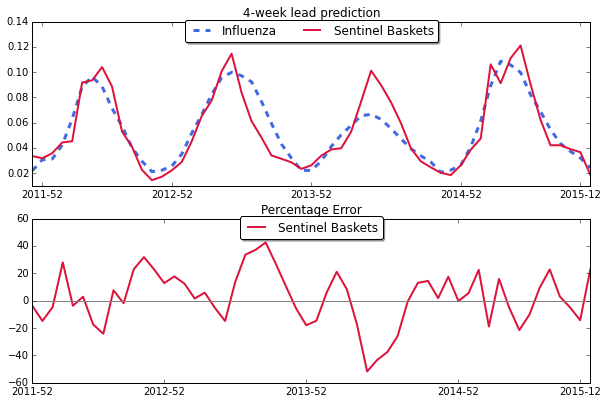

In [7]:
top = 1
for week in weeks:
    pe_proxy = []
    for i in range(0, len(all_flu[week][top])):
        pe_proxy.append(percentage_error(all_flu[week][top][i], all_proxy[week][top][i]))

    weeks_first = []
    t_v = [1,14,28,43,55]
    for i in t_v:
        weeks_first.append(all_weeks[week][top][i])

    t = range(0,len(all_flu[week][top]))
    fig = plt.figure(figsize=(10,10))

    # Influenza and sentinel baskets curves
    ax1 = fig.add_subplot(311)
    plt.xticks(t_v, weeks_first)
    plt.title("%d-week lead prediction" %week)
    plt.plot(t, all_flu[week][top], color='royalblue', linewidth=3, label='Influenza', linestyle='dashed')
    plt.plot(t, all_proxy[week][top], color='crimson', linewidth=2, label='Sentinel Baskets')
    plt.ylim((0.01,0.14))
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
              ncol=3, fancybox=True, shadow=True)

    # Percentage error
    ax3 = fig.add_subplot(312)
    plt.xticks(t_v, weeks_first)
    plt.title("Percentage Error")
    plt.plot(t[1:], pe_proxy[1:], color='crimson', linewidth=2, label='Sentinel Baskets')
    plt.ylim((-60,60))
    plt.axhline(y=0.0, color = 'grey')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3, fancybox=True, shadow=True)